In [261]:
import numpy as np
from qiskit import QuantumCircuit
from scipy.linalg import null_space

In [262]:
def create_simon_oracle(n_qubits, hidden_string):
    """Create a quantum circuit implementing the Simon oracle for a given hidden string."""
    oracle = QuantumCircuit(2 * n_qubits)

    # Apply identity transformation for input qubits to output qubits
    for i in range(n_qubits):
        oracle.cx(i, i + n_qubits)

    # If hidden string is all zeros, we're done (one-to-one function)
    if all(bit == '0' for bit in hidden_string):
        return oracle

    # Apply XOR with hidden string (two-to-one function)
    for i in range(n_qubits):
        if hidden_string[i] == '1':
            oracle.cx(i, i + n_qubits)  # XOR the output with input when bit is 1

    return oracle


In [263]:
def simon_algorithm(n_qubits, hidden_string):
    """Implement Simon's algorithm for finding the hidden string."""
    # Create the main circuit
    simon_circuit = QuantumCircuit(2 * n_qubits, n_qubits)

    # Apply Hadamard to the first n_qubits
    simon_circuit.h(range(n_qubits))

    simon_circuit.barrier()

    # Apply the oracle
    oracle = create_simon_oracle(n_qubits, hidden_string)
    simon_circuit = simon_circuit.compose(oracle)

    # Apply Hadamard to the first n_qubits again
    simon_circuit.barrier()
    simon_circuit.h(range(n_qubits))

    # Measure the first register
    simon_circuit.measure(range(n_qubits), range(n_qubits))

    return simon_circuit


In [264]:
def find_hidden_string(results, n_qubits):
    """Process measurement results to find the hidden string."""
    # Get the measured bit strings
    z_results = []
    for bitstring in results:
        if bitstring != '0' * n_qubits:  # Ignore all-zero results
            z_results.append([int(bit) for bit in bitstring])

    # If we have enough linearly independent equations
    if len(z_results) >= n_qubits - 1:
        # Find the null space
        z_matrix = np.array(z_results)
        ns = null_space(z_matrix.T % 2)
        if ns.size > 0:
            # Convert to binary string
            s = ''.join([str(int(round(x)) % 2) for x in ns.T[0]])
            return s

    return "Need more samples"


In [265]:
hidden_string = '0110'
n_qubits = 2

circuit = simon_algorithm(n_qubits, hidden_string)

In [266]:
circuit = QuantumCircuit(3, 2)

circuit.h(range(2))

circuit.barrier()
circuit.x(1)
circuit.ccx(0, 1, 2)
circuit.x(0)
circuit.x(1)
circuit.ccx(0, 1, 2)
circuit.x(0)
circuit.barrier()

circuit.h(range(2))

circuit.measure(range(2), range(2))

In [267]:
circuit.draw()

┌───┐ ░           ┌───┐     ┌───┐ ░ ┌───┐┌─┐   
q_0: ┤ H ├─░────────■──┤ X ├──■──┤ X ├─░─┤ H ├┤M├───
     ├───┤ ░ ┌───┐  │  ├───┤  │  └───┘ ░ ├───┤└╥┘┌─┐
q_1: ┤ H ├─░─┤ X ├──■──┤ X ├──■────────░─┤ H ├─╫─┤M├
     └───┘ ░ └───┘┌─┴─┐└───┘┌─┴─┐      ░ └───┘ ║ └╥┘
q_2: ──────░──────┤ X ├─────┤ X ├──────░───────╫──╫─
           ░      └───┘     └───┘      ░       ║  ║ 
c: 2/══════════════════════════════════════════╩══╩═
                                               0  1

In [268]:
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator

backend = AerSimulator()

sampler = BackendSamplerV2(backend=backend)

job = sampler.run([circuit], shots=1024)
result = job.result()

In [269]:
result[0].data.__dict__.keys()

dict_keys(['c'])

In [270]:
counts = result[0].data['c'].get_counts()

In [271]:
print("Measurement results:", counts)

Measurement results: {'00': 495, '11': 529}


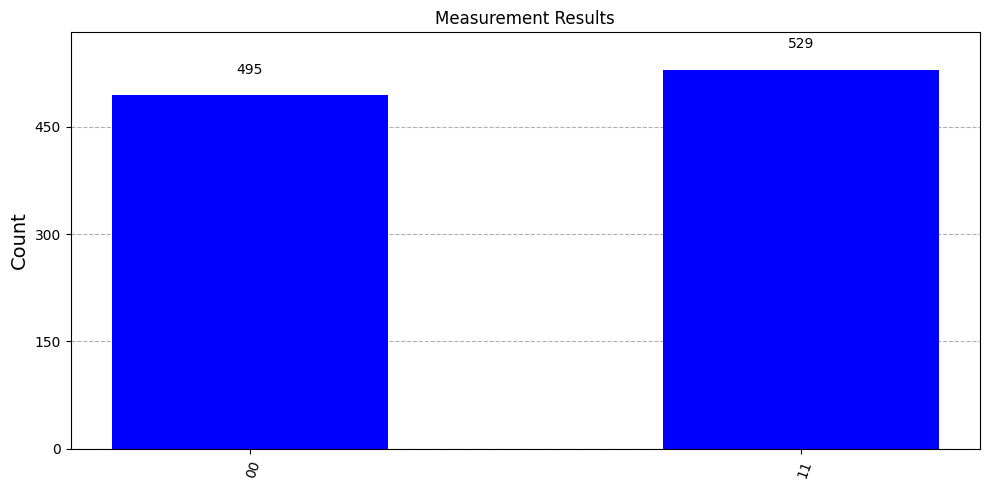

In [272]:
from qiskit.visualization import plot_histogram
plot_histogram(counts, title="Measurement Results", color='blue', figsize=(10, 5))

In [273]:
z_samples = list(counts.keys())
hidden = find_hidden_string(z_samples, n_qubits)
print(f"Hidden string: {hidden}")
print(f"Actual hidden string: {hidden_string}")

Hidden string: Need more samples
Actual hidden string: 0110


In [274]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        print(f"{i}")
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

b = hidden_string

print('b = ' + b)
for z in counts:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), counts[z]*100/1024))


b = 0110
0
1
2


IndexError: string index out of range